# ***Project Objectives***

- *Analyzing and preprocessing transaction data.*
- *Creating and engineering features that help identify fraud patterns.*
- *Building and training machine learning models to detect fraud.*
- *Evaluating model performance and making necessary improvements.*
- *Deploying the models for real-time fraud detection and setting up monitoring for continuous improvement.*


In [ ]:
## Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
import mlflow

In [73]:
## Load the dataset
df_fraud = pd.read_csv('../data/cleaned_fraud_data.csv')
df_credit_card = pd.read_csv('../data/creditcard.csv')

In [74]:
## View sample credit card data
df_credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [75]:
## View sample data
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,country,hour,...,weekday,frequency,velocity,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,0.172414,QVPSPJUOCKZAR,0.362069,0.170603,0,Japan,2,...,5,1,0.172414,False,True,False,False,False,False,True
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,0.048276,EOGFQPIZPYXFZ,0.603448,0.081554,0,United States,1,...,0,1,0.048276,False,False,False,False,False,False,False
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,0.041379,YSSKYOSJHPPLJ,0.603448,0.610371,1,United States,18,...,3,1,0.041379,False,True,False,False,True,False,True
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,0.241379,ATGTXKYKUDUQN,0.396552,0.894219,0,Unknown,13,...,0,1,0.241379,False,True,False,False,False,True,True
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,0.206897,NAUITBZFJKHWW,0.465517,0.096752,0,United States,18,...,2,1,0.206897,False,False,False,False,False,True,True


## ***Data Transformation***

In [76]:
## Normalize the 'Time' and 'Amount' features in the credit card data
cols = ['Time','Amount']
scaler = MinMaxScaler()
df_credit_card[cols]=scaler.fit_transform(df_credit_card[cols])

In [77]:
## Label encode the 'country' feature in the fraud datasets
label_encoder = LabelEncoder()
df_fraud['country'] = label_encoder.fit_transform(df_fraud['country'])

In [78]:
## Find the difference between signup and purchase time for fraud datasets
df_fraud['signup_time'] = pd.to_datetime(df_fraud['signup_time'])
df_fraud['purchase_time'] = pd.to_datetime(df_fraud['purchase_time'])
df_fraud['time_difference'] = (df_fraud['purchase_time'] - df_fraud['signup_time']).dt.total_seconds()

In [79]:
## Scale the the time_difference column
df_fraud['time_difference'] = scaler.fit_transform(df_fraud[['time_difference']])

In [80]:
## let's drop unwanted columns 
df_fraud.drop(columns=['user_id','signup_time','purchase_time','device_id','ip_address'], inplace=True)

In [81]:
## View Transformed credit data
df_credit_card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.005824,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.000105,0
2,0.000006,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.014739,0
3,0.000006,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.004807,0
4,0.000012,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.002724,0


In [82]:
## View Transformed Fraud data
df_fraud.head()

,purchase_value,age,class,country,hour,month,day,weekday,frequency,velocity,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,time_difference
0,0.172414,0.362069,0,84,2,4,18,5,1,0.172414,False,True,False,False,False,False,True,0.434673
1,0.048276,0.603448,0,171,1,6,8,0,1,0.048276,False,False,False,False,False,False,False,0.001731
2,0.041379,0.603448,1,171,18,1,1,3,1,0.041379,False,True,False,False,True,False,True,0.000000
3,0.241379,0.396552,0,172,13,5,4,0,1,0.241379,False,True,False,False,False,True,True,0.047462
4,0.206897,0.465517,0,171,18,9,9,2,1,0.206897,False,False,False,False,False,True,True,0.420667


## ***Train Test Split***

In [83]:
## Feature and Target Separation for both datasets
X_fraud = df_fraud.drop(columns=['class'])
y_fraud = df_fraud['class']

X_credit = df_credit_card.drop(columns=['Class'])
y_credit = df_credit_card['Class']

In [84]:
## 80-20 Training and Test dataset split

## For Fraud Data
X_train_fraud,X_test_fraud,y_train_fraud,y_test_fraud = train_test_split(X_fraud,y_fraud,test_size=0.2, random_state=42,stratify=y_fraud)

## For Credit Card Data
X_train_credit,X_test_credit,y_train_credit,y_test_credit = train_test_split(X_credit,y_credit,test_size=0.2, random_state=42,stratify=y_credit)


In [85]:
## Print the class distribution
print(f"The distribution of fraud class in the fraud dataset: {y_train_fraud.value_counts()}")
print(f"The distribution of fraud class in the credit dataset: {y_train_credit.value_counts()}")

The distribution of fraud class in the fraud dataset: class
0    109568
1     11321
Name: count, dtype: int64
The distribution of fraud class in the credit dataset: Class
0    227451
1       394
Name: count, dtype: int64


### ***Observation***
***As evident from the code above, there is a class imbalance in both datasets. To address this issue and enhance model performance, we will apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes.***

In [86]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

X_train_fraud_resampled, y_train_fraud_resampled = smote.fit_resample(X_train_fraud, y_train_fraud)
X_train_credit_resampled, y_train_credit_resampled = smote.fit_resample(X_train_credit,y_train_credit)

In [87]:
## Check for class imbalance
print(f"The distribution of fraud class in the fraud dataset: {y_train_fraud_resampled.value_counts()}")
print(f"The distribution of fraud class in the credit dataset: {y_train_credit_resampled.value_counts()}")

The distribution of fraud class in the fraud dataset: class
0    109568
1    109568
Name: count, dtype: int64
The distribution of fraud class in the credit dataset: Class
0    227451
1    227451
Name: count, dtype: int64


## ***Model Building and Training***

In [88]:
## Functions for model evaluation and confusion matrix plotting

## Function to evaluate the model
def evaluate_model(model,X_test,y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    conf_matrix = confusion_matrix(y_test,y_pred)
    return accuracy, report, conf_matrix

## Function to plot the confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### ***1. Logistic Regression Model***

In [89]:
def train_model_lgr(X_train, y_train):
    ## Initialize the model
    lgr = LogisticRegression(max_iter=1000,random_state=42)
    ## Fit the model
    lgr.fit(X_train, y_train)
    return lgr

In [90]:
## fit the model on the resampled fraud dataset and credit card dataset
model_fraud = train_model_lgr(X_train_fraud_resampled, y_train_fraud_resampled)
model_credit = train_model_lgr(X_train_credit_resampled, y_train_credit_resampled)

In [91]:
## Evaluate the model on the test dataset
accuracy_fraud, report_fraud, conf_matrix_fraud = evaluate_model(model_fraud,X_test_fraud,y_test_fraud)
accuracy_credit, report_credit, conf_matrix_credit = evaluate_model(model_credit,X_test_credit,y_test_credit)

print(f"Fraud Dataset: Accuracy: {accuracy_fraud}")
print(f"Fraud Dataset: Classification Report:")
print(report_fraud)


print(f"Credit Card Dataset: Accuracy: {accuracy_credit}")
print(f"Credit Card Dataset: Classification Report:")
print(report_credit)


Fraud Dataset: Accuracy: 0.7522416702511332
Fraud Dataset: Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85     27393
           1       0.22      0.64      0.33      2830

    accuracy                           0.75     30223
   macro avg       0.59      0.70      0.59     30223
weighted avg       0.89      0.75      0.80     30223

Credit Card Dataset: Accuracy: 0.9740704329201925
Credit Card Dataset: Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



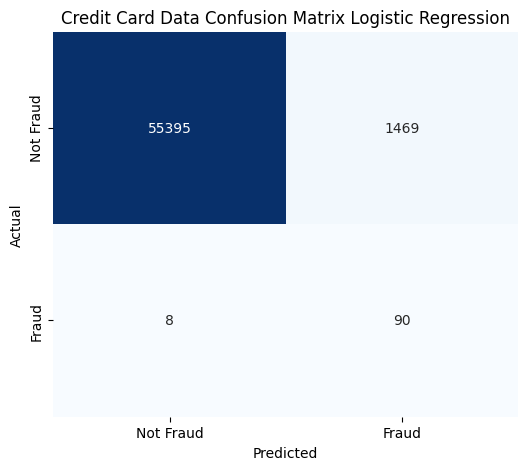

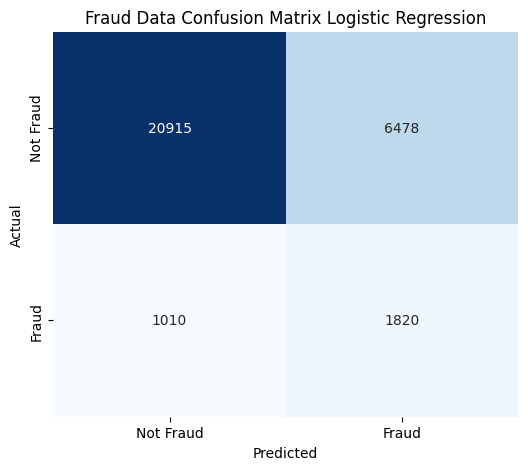

In [92]:
# Plot for Credit Card Data
plot_confusion_matrix(conf_matrix_credit, title='Credit Card Data Confusion Matrix Logistic Regression')

# Plot for Fraud Data
plot_confusion_matrix(conf_matrix_fraud, title='Fraud Data Confusion Matrix Logistic Regression')

In [93]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Logistic Regression Model for Fraud Dataset")

# Start an MLflow run for fraud dataset
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params({"max_iter": 1000, "random_state": 42})

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_fraud)

    # Log the classification report
    mlflow.log_param("classification_report", report_fraud)

    # Log the model
    mlflow.sklearn.log_model(model_fraud, "model")


2025/02/11 13:50:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run receptive-stork-223 at: http://127.0.0.1:5000/#/experiments/568887781401905765/runs/c4ce1c5a4cc945e0aa6347ba836bbcae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/568887781401905765


In [94]:
# Create a new MLflow Experiment
mlflow.set_experiment("Logistic Regression Model for Credit Card Dataset")

# Start an MLflow run for fraud dataset
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params({"max_iter": 1000, "random_state": 42})

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_credit)

    # Log the classification report
    mlflow.log_param("classification_report", report_credit)

    # Log the model
    mlflow.sklearn.log_model(model_credit, "model")

2025/02/11 13:51:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run powerful-grouse-403 at: http://127.0.0.1:5000/#/experiments/763447790967217867/runs/d53e5ac9964e4402bc118eb3cbf2283b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/763447790967217867


### ***2. Decision Tree Model***

In [95]:
## define a function to train the model
def train_model_tree(X_train, y_train):
    ## Initialize the model
    tree = DecisionTreeClassifier(random_state=42)
    ## Fit the model
    tree.fit(X_train, y_train)
    return tree

In [96]:
## fit the model on the resampled fraud dataset and credit card dataset
model_fraud_tree = train_model_tree(X_train_fraud_resampled, y_train_fraud_resampled)
model_credit_tree = train_model_tree(X_train_credit_resampled, y_train_credit_resampled)

In [97]:
## Evaluate the model on the test dataset
accuracy_fraud_tree, report_fraud_tree, conf_matrix_fraud_tree = evaluate_model(model_fraud_tree,X_test_fraud,y_test_fraud)
accuracy_credit_tree, report_credit_tree, conf_matrix_credit_tree = evaluate_model(model_credit_tree,X_test_credit,y_test_credit)

print(f"Fraud Dataset: Accuracy: {accuracy_fraud_tree}")
print(f"Fraud Dataset: Classification Report:")
print(report_fraud_tree)


print(f"Credit Card Dataset: Accuracy: {accuracy_credit_tree}")
print(f"Credit Card Dataset: Classification Report:")
print(report_credit_tree)

Fraud Dataset: Accuracy: 0.865003474175297
Fraud Dataset: Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     27393
           1       0.36      0.57      0.44      2830

    accuracy                           0.87     30223
   macro avg       0.66      0.73      0.68     30223
weighted avg       0.90      0.87      0.88     30223

Credit Card Dataset: Accuracy: 0.9973666654962958
Credit Card Dataset: Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.37      0.79      0.51        98

    accuracy                           1.00     56962
   macro avg       0.69      0.89      0.75     56962
weighted avg       1.00      1.00      1.00     56962



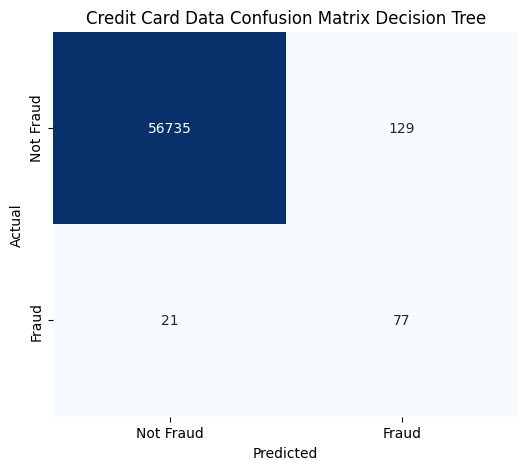

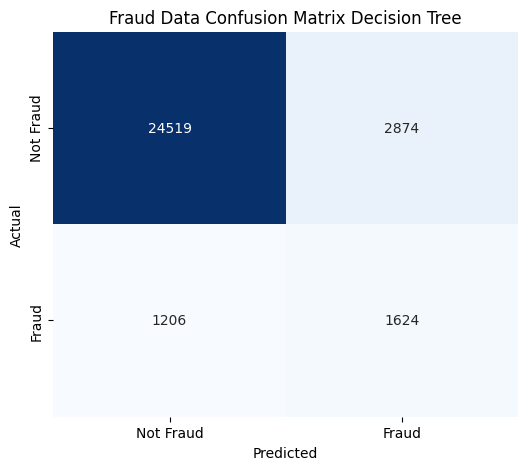

In [98]:
# Plot for Credit Card Data
plot_confusion_matrix(conf_matrix_credit_tree, title='Credit Card Data Confusion Matrix Decision Tree')

# Plot for Fraud Data
plot_confusion_matrix(conf_matrix_fraud_tree, title='Fraud Data Confusion Matrix Decision Tree')

In [99]:
# Create a new MLflow Experiment
mlflow.set_experiment("Decision Tree Model for Fraud Dataset")

# Start an MLflow run for fraud dataset
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_param("random_state", 42)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_fraud_tree)

    # Log the classification report
    mlflow.log_param("classification_report", report_fraud_tree)

    # Log the model
    mlflow.sklearn.log_model(model_fraud_tree, "model")

2025/02/11 13:52:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run intelligent-ray-417 at: http://127.0.0.1:5000/#/experiments/854806366494140679/runs/6b57b89e8a6a4f6baff5fb25a1f2869d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/854806366494140679


In [100]:
# Create a new MLflow Experiment
mlflow.set_experiment("Decision Tree Model for Credit Dataset")

# Start an MLflow run for fraud dataset
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_param("random_state", 42)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_credit_tree)

    # Log the classification report
    mlflow.log_param("classification_report", report_credit_tree)

    # Log the model
    mlflow.sklearn.log_model(model_credit_tree, "model")

2025/02/11 13:52:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run zealous-skink-183 at: http://127.0.0.1:5000/#/experiments/462150722337314884/runs/1821896cb8b342e6be2fa88617b90e25
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/462150722337314884


### ***3. Random Forest Model***

In [101]:
## define a function to train the model
def train_model_rfc(X_train, y_train):
    ## Initialize the model
    rfc = RandomForestClassifier(random_state=42)
    ## Fit the model
    rfc.fit(X_train, y_train)
    return rfc

In [102]:
## fit the model on the resampled fraud dataset and credit card dataset
model_fraud_rfc = train_model_rfc(X_train_fraud_resampled, y_train_fraud_resampled)
model_credit_rfc = train_model_rfc(X_train_credit_resampled, y_train_credit_resampled)

In [103]:
## Evaluate the model on the test dataset
accuracy_fraud_rfc, report_fraud_rfc, conf_matrix_fraud_rfc = evaluate_model(model_fraud_rfc,X_test_fraud,y_test_fraud)
accuracy_credit_rfc, report_credit_rfc, conf_matrix_credit_rfc = evaluate_model(model_credit_rfc,X_test_credit,y_test_credit)

print(f"Fraud Dataset: Accuracy: {accuracy_fraud_rfc}")
print(f"Fraud Dataset: Classification Report:")
print(report_fraud_rfc)


print(f"Credit Card Dataset: Accuracy: {accuracy_credit_rfc}")
print(f"Credit Card Dataset: Classification Report:")
print(report_credit_rfc)

Fraud Dataset: Accuracy: 0.9429573503623069
Fraud Dataset: Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27393
           1       0.79      0.53      0.64      2830

    accuracy                           0.94     30223
   macro avg       0.87      0.76      0.80     30223
weighted avg       0.94      0.94      0.94     30223

Credit Card Dataset: Accuracy: 0.9994382219725431
Credit Card Dataset: Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.82      0.83        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



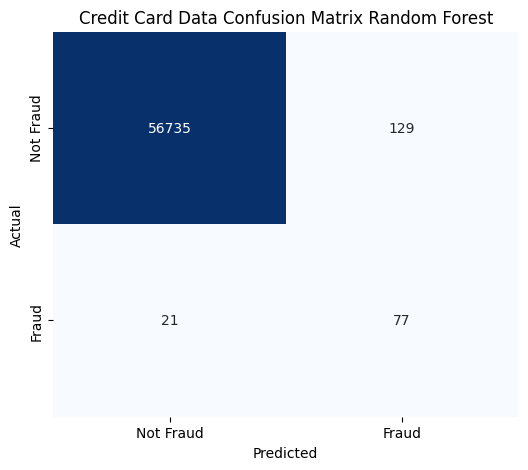

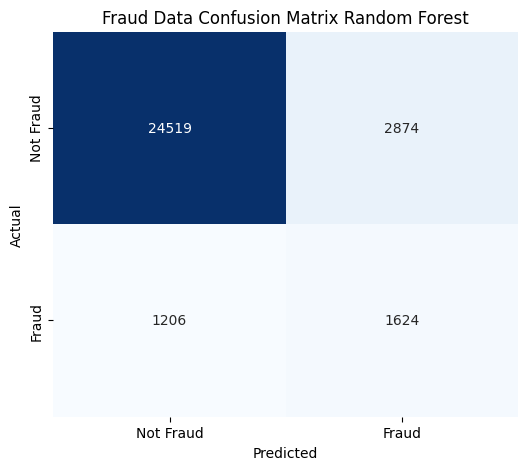

In [104]:
# Plot for Credit Card Data
plot_confusion_matrix(conf_matrix_credit_tree, title='Credit Card Data Confusion Matrix Random Forest')

# Plot for Fraud Data
plot_confusion_matrix(conf_matrix_fraud_tree, title='Fraud Data Confusion Matrix Random Forest')

In [105]:
# Create a new MLflow Experiment
mlflow.set_experiment("Random Forest Model for Fraud Dataset")

# Start an MLflow run for fraud dataset
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_param("random_state", 42)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_fraud_rfc)

    # Log the classification report
    mlflow.log_param("classification_report", report_fraud_rfc)

    # Log the model
    mlflow.sklearn.log_model(model_fraud_rfc, "model")

2025/02/11 14:16:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run gentle-ape-546 at: http://127.0.0.1:5000/#/experiments/608135780720652931/runs/1931e2752fef4750b846fc663c2595ca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/608135780720652931


In [106]:
# Create a new MLflow Experiment
mlflow.set_experiment("Random Forest Model for Credit Dataset")

# Start an MLflow run for fraud dataset
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_param("random_state", 42)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_credit_rfc)

    # Log the classification report
    mlflow.log_param("classification_report", report_credit_rfc)

    # Log the model
    mlflow.sklearn.log_model(model_credit_rfc, "model")

2025/02/11 14:17:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run traveling-ant-104 at: http://127.0.0.1:5000/#/experiments/762204469868388553/runs/bf95ea41b7714fd0bbffbe6ab2f81f6f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/762204469868388553


### ***4. XGBoost Model***

In [107]:
## define a function to train the model
def train_model_xgb(X_train, y_train):
    ## Initialize the model
    xgb = XGBClassifier(random_state=42, eval_metric='logloss')
    ## Fit the model
    xgb.fit(X_train, y_train)
    return xgb

In [108]:
## fit the model on the resampled fraud dataset and credit card dataset
model_fraud_xgb = train_model_xgb(X_train_fraud_resampled, y_train_fraud_resampled)
model_credit_xgb = train_model_xgb(X_train_credit_resampled, y_train_credit_resampled)

In [109]:
## Evaluate the model on the test dataset
accuracy_fraud_xgb, report_fraud_xgb, conf_matrix_fraud_xgb = evaluate_model(model_fraud_xgb,X_test_fraud,y_test_fraud)
accuracy_credit_xgb, report_credit_xgb, conf_matrix_credit_xgb = evaluate_model(model_credit_xgb,X_test_credit,y_test_credit)

print(f"Fraud Dataset: Accuracy: {accuracy_fraud_xgb}")
print(f"Fraud Dataset: Classification Report:")
print(report_fraud_xgb)


print(f"Credit Card Dataset: Accuracy: {accuracy_credit_xgb}")
print(f"Credit Card Dataset: Classification Report:")
print(report_credit_xgb)

Fraud Dataset: Accuracy: 0.9544717599179433
Fraud Dataset: Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.97      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.96      0.76      0.83     30223
weighted avg       0.96      0.95      0.95     30223

Credit Card Dataset: Accuracy: 0.9991397773954567
Credit Card Dataset: Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.87      0.78        98

    accuracy                           1.00     56962
   macro avg       0.85      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962



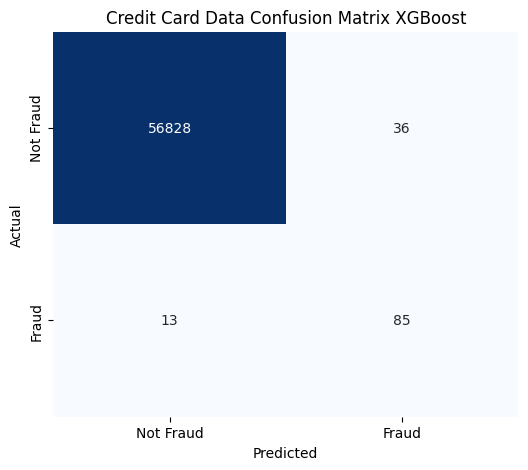

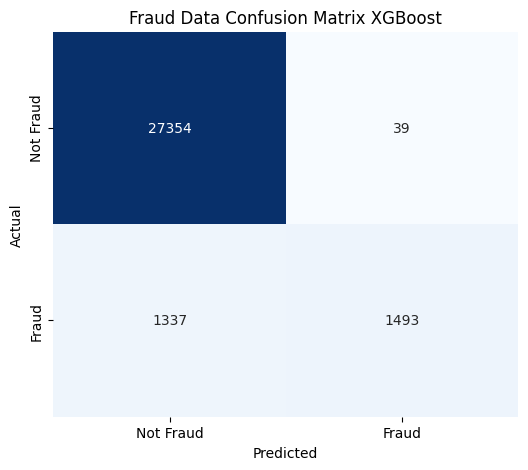

In [110]:
# Plot for Credit Card Data
plot_confusion_matrix(conf_matrix_credit_xgb, title='Credit Card Data Confusion Matrix XGBoost')

# Plot for Fraud Data
plot_confusion_matrix(conf_matrix_fraud_xgb, title='Fraud Data Confusion Matrix XGBoost')

In [111]:
# Create a new MLflow Experiment
mlflow.set_experiment("XGBoost Model for Fraud Dataset")

# Start an MLflow run for fraud dataset
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_param("random_state", 42)
    mlflow.log_param("eval_metric", 'logloss')

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_fraud_xgb)

    # Log the classification report
    mlflow.log_param("classification_report", report_fraud_xgb)

    # Log the model
    mlflow.sklearn.log_model(model_fraud_xgb, "model")

2025/02/11 14:17:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run dapper-kit-425 at: http://127.0.0.1:5000/#/experiments/920684016056485518/runs/e05a974eb47e41c5883301716de2f279
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/920684016056485518


In [112]:
# Create a new MLflow Experiment
mlflow.set_experiment("XGBoost Model for Credit Card Dataset")

# Start an MLflow run for fraud dataset
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_param("random_state", 42)
    mlflow.log_param("eval_metric", 'logloss')

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_credit_xgb)

    # Log the classification report
    mlflow.log_param("classification_report", report_credit_xgb)

    # Log the model
    mlflow.sklearn.log_model(model_credit_xgb, "model")

2025/02/11 14:17:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run able-stoat-370 at: http://127.0.0.1:5000/#/experiments/916531310383500869/runs/27fc10be2dfc4530abbd561cbd20e866
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/916531310383500869
